In [ ]:
!pip install open3d --q
!pip install plotly --q
!pip install pyntcloud --q

# IMPORTING LIBRARIES

In [2]:
import open3d as o3d
import numpy as np
import pandas as pd
import os
import re
from glob import glob
import time
import random
import seaborn as sns
import xml.etree.ElementTree as ET
from mpl_toolkits.mplot3d import Axes3D
from pyntcloud import PyntCloud
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt 
from plotly.offline import iplot, init_notebook_mode

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import torch.optim as optim


import warnings
warnings.filterwarnings("ignore")

init_notebook_mode(connected=True)
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Load Sample the PLY file
ply_file = "/kaggle/input/point-cloud-lidar-toronto-3d/L002.ply"  # Replace with your file path
cloud = PyntCloud.from_file(ply_file)

# Print point cloud information
print(cloud)

# Convert to Pandas DataFrame
df = cloud.points
UTM_OFFSET = np.array([627285, 4841948, 0])
df[['x', 'y', 'z']] -= UTM_OFFSET
df.head()

PyntCloud
10283800 points with 7 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: 627511.59871491, 4842581.018657005, 136.91529315746322
Other attributes:
	 comments: <class 'list'>



,x,y,z,red,green,blue,scalar_Intensity,scalar_GPSTime,scalar_ScanAngleRank,scalar_Label
0,190.236000,718.848022,143.332993,98,88,27,2.0,324794.09375,29.0,3.0
1,190.694000,719.401001,143.031006,93,84,55,8.0,324794.15625,29.0,3.0
2,190.584000,719.551025,142.955002,99,82,54,6.0,324794.15625,29.0,3.0
3,190.387001,719.572998,142.873001,74,67,74,4.0,324794.15625,29.0,3.0
4,190.780998,719.507996,143.067001,87,55,44,8.0,324794.21875,27.0,3.0


# VISUALIZE SAMPLE DATA

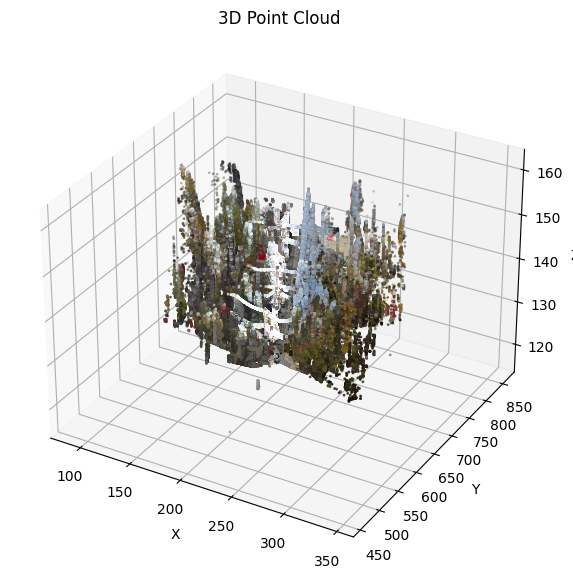

In [4]:
# Extract RGB values and normalize them to [0, 1] range
rgb_colors = df[['red', 'green', 'blue']].values / 255.0

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with RGB colors
sc = ax.scatter(
    df['x'],
    df['y'],
    df['z'],
    c=rgb_colors,
    s=1,  # Adjust point size
    marker='o'
)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Point Cloud')
plt.show()

In [5]:
# Load and parse XML file
def parse_color_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    # Namespace (if needed)
    ns = {'cc': 'http://www.cloudcompare.org/'}
    # Extract color steps
    color_steps = root.find('.//Data', ns)
    color_map = {}
    for step in color_steps.findall('step'):
        r = int(step.get('r'))
        g = int(step.get('g'))
        b = int(step.get('b'))
        pos = float(step.get('pos'))
        color_map[int(pos * 8)] = (r / 255.0, g / 255.0, b / 255.0)
    return color_map

# Map of labels to categories
label_categories = {
    0: 'Unclassified',1: 'Ground',2: 'Road_markings',3: 'Natural',4: 'Building',
    5: 'Utility_line',6: 'Pole',7: 'Car', 8: 'Fence'
}

# Map of categories to colors (parsed from XML)
def get_category_colors(color_map):
    return {i: color_map[i] for i in label_categories.keys() if i in color_map}

# Example XML file path
xml_file = '/kaggle/input/point-cloud-lidar-toronto-3d/Colors.xml'
color_map = parse_color_xml(xml_file)
category_colors = get_category_colors(color_map)

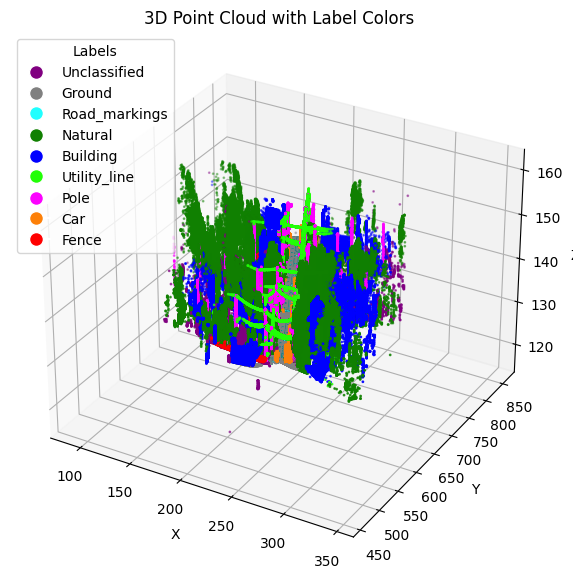

In [6]:
df['color'] = df.apply(lambda row: f'rgb({row.red},{row.green},{row.blue})', axis=1)
# Map label colors using the color map
scatter_colors = df['scalar_Label'].map(color_map)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with label colors
sc = ax.scatter(
    df['x'],
    df['y'],
    df['z'],
    c=[color_map.get(label, (1, 1, 1)) for label in df['scalar_Label']],
    s=1,  # Adjust point size
    marker='o'
)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Point Cloud with Label Colors')

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=category_colors[i], markersize=10, label=label_categories[i]) for i in sorted(category_colors)]
ax.legend(handles=handles, title='Labels')

plt.show()

In [7]:
def plot_3D(sampled_df):
    # Extract RGB values and normalize them to [0, 1] range
    rgb_colors = sampled_df[['red', 'green', 'blue']].values / 255.0

    # Create a 3D scatter plot
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=sampled_df['x'],
        y=sampled_df['y'],
        z=sampled_df['z'],
        mode='markers',
        marker=dict(
            size=1,  # Adjust point size
            color=rgb_colors,  # Set color using RGB values
            opacity=0.8  # Adjust marker opacity if needed
        )
        ))

    # Set labels
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'),
        title='3D Point Cloud')

    fig.show()

In [ ]:
sampled_df = df.sample(n=100000, random_state=42)
plot_3D(sampled_df)

In [ ]:
# Load the PLY file
ply_file_1 = "/kaggle/input/point-cloud-lidar-toronto-3d/L001.ply"
ply_file_2 = "/kaggle/input/point-cloud-lidar-toronto-3d/L002.ply"
ply_file_3 = "/kaggle/input/point-cloud-lidar-toronto-3d/L003.ply"
ply_file_4 = "/kaggle/input/point-cloud-lidar-toronto-3d/L004.ply"

cloud_1 = PyntCloud.from_file(ply_file_1)
cloud_2 = PyntCloud.from_file(ply_file_2)
cloud_3 = PyntCloud.from_file(ply_file_3)
cloud_4 = PyntCloud.from_file(ply_file_4)

# Print point cloud information
print(cloud_1)
print(cloud_2)
print(cloud_3)
print(cloud_4)

# Convert to Pandas DataFrame
df_1 = cloud_1.points
df_2 = cloud_2.points
df_3 = cloud_3.points
df_4 = cloud_4.points

full_df = pd.concat([df_1, df_2, df_3, df_4])

In [10]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78320210 entries, 0 to 6747647
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   x                     float64
 1   y                     float64
 2   z                     float64
 3   red                   uint8  
 4   green                 uint8  
 5   blue                  uint8  
 6   scalar_Intensity      float32
 7   scalar_GPSTime        float32
 8   scalar_ScanAngleRank  float32
 9   scalar_Label          float32
dtypes: float32(4), float64(3), uint8(3)
memory usage: 3.7 GB


In [11]:
category_mapping = {
    0: 'Unclassified',1: 'Ground',2: 'Road_markings',3: 'Natural',4: 'Building',
    5: 'Utility_line',6: 'Pole',7: 'Car', 8: 'Fence'
}
# Create new column with category names
full_df['label_name'] = full_df['scalar_Label'].map(category_mapping)
full_df[['x', 'y', 'z']] -= UTM_OFFSET
full_df.head()

,x,y,z,red,green,blue,scalar_Intensity,scalar_GPSTime,scalar_ScanAngleRank,scalar_Label,label_name
0,152.931000,847.692993,138.695007,185,177,166,11.0,324786.78125,30.0,1.0,Ground
1,152.951996,847.723022,138.695007,180,169,165,11.0,324786.78125,30.0,1.0,Ground
2,152.867996,847.875977,138.699005,185,178,168,15.0,324786.78125,28.0,1.0,Ground
3,152.886002,847.903015,138.697006,186,179,169,15.0,324786.78125,28.0,1.0,Ground
4,153.233994,846.755981,138.677002,185,179,165,11.0,324786.84375,30.0,1.0,Ground


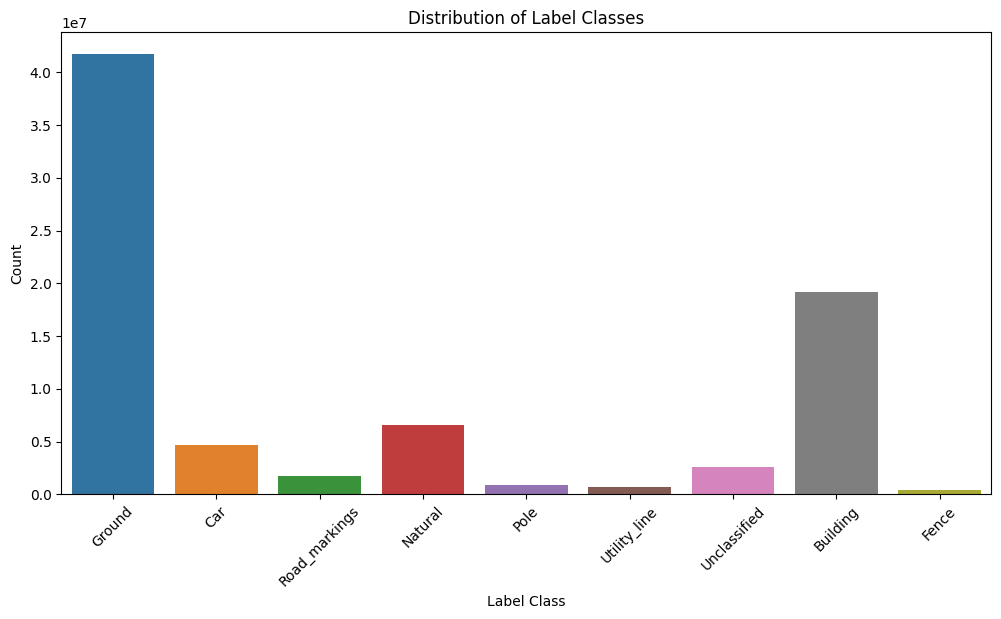

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(data=full_df, x='label_name')
plt.title('Distribution of Label Classes')
plt.xlabel('Label Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# DATALOADER

In [13]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class PointCloudDataset(Dataset):
    def __init__(self, df, num_points=4096, augmentation=None, r_prob=0.25):
        self.df = df
        self.num_points = num_points
        self.augmentation = augmentation
        self.r_prob = r_prob

    def __len__(self):
        return len(self.df) // self.num_points
    
    def random_rotate(self, points):
        ''' randomly rotates point cloud about vertical axis.'''
        phi = np.random.uniform(-np.pi, np.pi)
        theta = np.random.uniform(-np.pi, np.pi)
        psi = np.random.uniform(-np.pi, np.pi)

        rot_x = np.array([
            [1, 0, 0],
            [0, np.cos(phi), -np.sin(phi)],
            [0, np.sin(phi), np.cos(phi)]
        ])

        rot_y = np.array([
            [np.cos(theta), 0, np.sin(theta)],
            [0, 1, 0],
            [-np.sin(theta), 0, np.cos(theta)]
        ])

        rot_z = np.array([
            [np.cos(psi), -np.sin(psi), 0],
            [np.sin(psi), np.cos(psi), 0],
            [0, 0, 1]
        ])

        return np.matmul(points, rot_z)
    
    def __getitem__(self, idx):
        start_idx = idx * self.num_points
        end_idx = start_idx + self.num_points
        batch_df = self.df.iloc[start_idx:end_idx]

        coords = batch_df[['x', 'y', 'z']].values
        #Normalize Points
        point_cloud = (coords - np.mean(coords, axis=0)) / np.std(coords, axis=0)
        
        labels = batch_df['scalar_Label'].values
        
        if self.augmentation != 'False':
            # Random Gaussian Noise
            point_cloud += np.random.normal(0., 0.01, point_cloud.shape)
            # Random rotate 
            if np.random.uniform(0, 1) > 1 - self.r_prob:
                point_cloud[:, :3] = self.random_rotate(point_cloud[:, :3])

            point_cloud += np.random.normal(0, 0.02, size=point_cloud.shape)

        return torch.tensor(point_cloud, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)

In [14]:
# feature selection hyperparameters
label_categories = ['Unclassified', 'Ground', 'Road Markings', 'Natural', 'Building', 'Utility Line', 'Pole', 'Car', 'Fence']
NUM_TRAIN_POINTS = 4096 # train/valid points
NUM_TEST_POINTS = 30000
NUM_CLASSES = len(label_categories)

In [15]:
train_df, test_val_df = train_test_split(full_df, test_size=0.3, stratify=full_df['scalar_Label'])
test_df, val_df = train_test_split(test_val_df, test_size=0.3, stratify=test_val_df['scalar_Label'])
print(train_df.shape, test_df.shape, val_df.shape)

(54824147, 11) (16447244, 11) (7048819, 11)


In [16]:
train_dataset = PointCloudDataset(train_df, augmentation=True)
val_dataset = PointCloudDataset(val_df, augmentation=False, r_prob=0.)
test_dataset = PointCloudDataset(test_df, augmentation=False, num_points=NUM_TEST_POINTS)


# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
def plot_3D_colors(sample_df):
        # Define color map and categories
    color_map = {
        0: 'purple',
        1: 'gray',
        2: 'cyan',
        3: 'dark green',
        4: 'blue',
        5: 'lime green',
        6: 'magenta',
        7: 'orange',
        8: 'red'
    }
    
    label_categories = ['Unclassified', 'Ground', 'Road Markings', 'Natural', 'Building', 'Utility Line', 'Pole', 'Car', 'Fence']

    # Map label colors using the color map
    scatter_colors = sampled_df['label'].map(color_map)

    # Create a 3D scatter plot
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=sampled_df['x'],
        y=sampled_df['y'],
        z=sampled_df['z'],
        mode='markers',
        marker=dict(
            size=1,  # Adjust point size
            color=scatter_colors,  # Set color using label colors
            opacity=0.5  # Adjust marker opacity if needed
        )
    ))

    # Add legend
    for label, color in color_map.items():
        fig.add_trace(go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=10, color=color),
            name=label_categories[label]
        ))

    # Set labels and title
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='3D Point Cloud with Label Colors',
        legend_title='Labels'
    )

    fig.show()

In [18]:
# Extract a batch from the train_loader
batch = next(iter(test_loader))

# Separate the point cloud data and labels
point_cloud_batch, labels_batch = batch

# Select the first sample in the batch (index 0)
sample_point_cloud = point_cloud_batch[0].numpy()
sample_labels = labels_batch[0].numpy()

In [19]:
# Convert the point cloud sample to a DataFrame
sampled_df = pd.DataFrame(sample_point_cloud, columns=['x', 'y', 'z'])
sampled_df['label'] = sample_labels
sampled_df.head()

,x,y,z,label
0,0.707320,-0.808673,-0.824091,1
1,0.476223,0.007361,-0.235322,3
2,0.110839,-0.028787,-0.859552,2
3,0.626516,-0.558659,-0.862617,1
4,0.740065,-0.812625,-0.833666,1


In [ ]:
plot_3D_colors(sampled_df)

# MODEL BUILDING

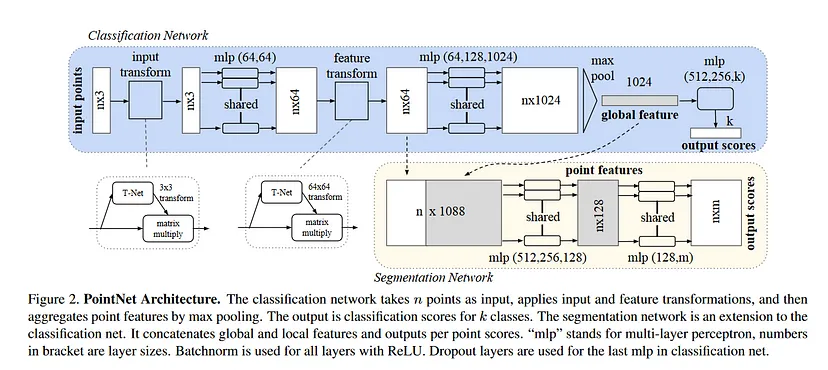

[Link](https://medium.com/@itberrios6/point-net-from-scratch-78935690e496)

### PointNet
PointNet is a deep learning model designed for processing and analyzing point cloud data, which represents three-dimensional (3D) spatial information.

Point clouds are collections of points in 3D space, often obtained from 3D sensors like LiDAR or depth cameras.

PointNet was introduced in the paper titled "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation" by Charles R. Qi, Hao Su, Kaichun Mo, and Leonidas J. Guibas, which was presented at the Conference on Computer Vision and Pattern Recognition (CVPR) in 2017.

### Input:
PointNet takes a set of 3D points as input, where each point is represented by its (x, y, z) coordinates. The input can be a variable-sized point cloud, making PointNet applicable to different scenarios with varying numbers of points.

### Architecture:
PointNet's architecture is designed to be permutation invariant, meaning that the model's output should be the same regardless of the order of the input points. This is crucial for processing point clouds, as the order of the points may vary. The architecture employs a shared multi-layer perceptron (MLP) network to process each point independently, extracting local features. A symmetric function (max pooling) is then applied to aggregate information from all points into a global feature vector, capturing the overall structure of the point cloud.
https://www.kaggle.com/code/nikolous/pointnet#Network-Components:

In [21]:
# The model architecture was refactored from this github, which we tweaked for our use case,
# https://github.com/itberrios/3D/blob/main/point_net/point_net.py


# ============================================================================
# T-net (Spatial Transformer Network)
class Tnet(nn.Module):
    ''' T-Net learns a Transformation matrix with a specified dimension '''
    def __init__(self, dim, num_points=4096):
        super(Tnet, self).__init__()

        # dimensions for transform matrix
        self.dim = dim 

        self.conv1 = nn.Conv1d(dim, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)

        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, dim**2)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points)
        

    def forward(self, x):
        bs = x.shape[0]

        # pass through shared MLP layers (conv1d)
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))

        # max pool over num points
        x = self.max_pool(x).view(bs, -1)
        
        # pass through MLP
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.bn5(F.relu(self.linear2(x)))
        x = self.linear3(x)

        # initialize identity matrix
        iden = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)
        if x.is_cuda:
            iden = iden.cuda()

        x = x.view(-1, self.dim, self.dim) + iden

        return x


# ============================================================================
# Point Net Backbone (main Architecture)
class PointNetBackbone(nn.Module):
    '''
    This is the main portion of Point Net before the classification and segmentation heads.
    The main function of this network is to obtain the local and global point features, 
    which can then be passed to each of the heads to perform either classification or
    segmentation. The forward pass through the backbone includes both T-nets and their 
    transformations, the shared MLPs, and the max pool layer to obtain the global features.

    The forward function either returns the global or combined (local and global features)
    along with the critical point index locations and the feature transformation matrix. The
    feature transformation matrix is used for a regularization term that will help it become
    orthogonal. (i.e. a rigid body transformation is an orthogonal transform and we would like
    to maintain orthogonality in high dimensional space). "An orthogonal transformations preserves
    the lengths of vectors and angles between them"
    ''' 
    def __init__(self, num_points=4096, num_global_feats=1024, local_feat=True):
        ''' Initializers:
                num_points - number of points in point cloud
                num_global_feats - number of Global Features for the main 
                                   Max Pooling layer
                local_feat - if True, forward() returns the concatenation 
                             of the local and global features
            '''
        super(PointNetBackbone, self).__init__()

        # if true concat local and global features
        self.num_points = num_points
        self.num_global_feats = num_global_feats
        self.local_feat = local_feat

        # Spatial Transformer Networks (T-nets)
        self.tnet1 = Tnet(dim=3, num_points=num_points)
        self.tnet2 = Tnet(dim=64, num_points=num_points)

        # shared MLP 1
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)

        # shared MLP 2
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv5 = nn.Conv1d(128, self.num_global_feats, kernel_size=1)
        
        # batch norms for both shared MLPs
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(self.num_global_feats)

        # max pool to get the global features
        self.max_pool = nn.MaxPool1d(kernel_size=num_points, return_indices=True)

    
    def forward(self, x):

        # get batch size
        bs = x.shape[0]
        
        # pass through first Tnet to get transform matrix
        A_input = self.tnet1(x)

        # perform first transformation across each point in the batch
        x = torch.bmm(x.transpose(2, 1), A_input).transpose(2, 1)

        # pass through first shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        
        # get feature transform
        A_feat = self.tnet2(x)

        # perform second transformation across each (64 dim) feature in the batch
        x = torch.bmm(x.transpose(2, 1), A_feat).transpose(2, 1)

        # store local point features for segmentation head
        local_features = x.clone()

        # pass through second MLP
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))

        # get global feature vector and critical indexes
        global_features, critical_indexes = self.max_pool(x)
        global_features = global_features.view(bs, -1)
        critical_indexes = critical_indexes.view(bs, -1)

        if self.local_feat:
            features = torch.cat((local_features, 
                                  global_features.unsqueeze(-1).repeat(1, 1, self.num_points)), 
                                  dim=1)

            return features, critical_indexes, A_feat

        else:
            return global_features, critical_indexes, A_feat



# ============================================================================
# Segmentation Head
class PointNetSegHead(nn.Module):
    ''' Segmentation Head '''
    def __init__(self, num_points=4096, num_global_feats=1024, m=2):
        super(PointNetSegHead, self).__init__()

        self.num_points = num_points
        self.m = m

        # get the backbone 
        self.backbone = PointNetBackbone(num_points, num_global_feats, local_feat=True)

        # shared MLP
        num_features = num_global_feats + 64 # local and global features
        self.conv1 = nn.Conv1d(num_features, 512, kernel_size=1)
        self.conv2 = nn.Conv1d(512, 256, kernel_size=1)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=1)
        self.conv4 = nn.Conv1d(128, m, kernel_size=1)

        # batch norms for shared MLP
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)


    def forward(self, x):
        
        # get combined features
        x, crit_idxs, A_feat = self.backbone(x) 

        # pass through shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.conv4(x)

        x = x.transpose(2, 1)
        
        return x, crit_idxs, A_feat

In [22]:
seg_model = PointNetSegHead(num_points=NUM_TRAIN_POINTS, m=NUM_CLASSES)
points, targets = next(iter(train_loader))
out, _, _ = seg_model(points.transpose(2, 1))
print(f'Seg shape: {out.shape}')

Seg shape: torch.Size([32, 4096, 9])


# CUSTOMIZED LOSS FOR SEGMENTATION

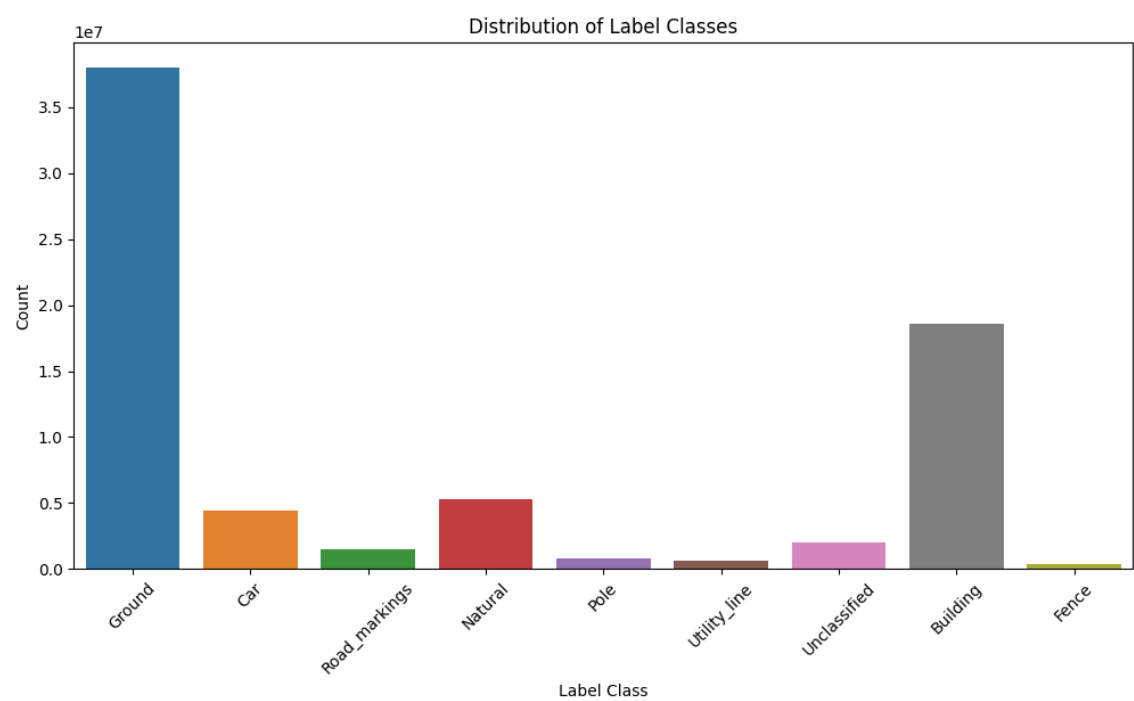

Our dataset is heavily imbalanced, with common categories like "Ground" and "Building" significantly outnumbering the other classes. If we were to train using a standard loss function like Cross Entropy, it would treat all classes as equally important. However, in practice, we want our model to pay more attention to the less common categories and not overly prioritize the more prevalent ones.

To address this imbalance, we will use a custom weighted loss function, adapted from the repository we referenced for the PointNet model [source](https://github.com/itberrios/3D/blob/main/point_net/point_net_loss.py). This approach helps the model focus on the more challenging classes (hard examples) while giving less emphasis to the easier ones.

The core of our loss function is based on Focal Loss, an enhancement of Cross Entropy that is particularly effective for imbalanced datasets. Focal Loss shifts the focus to the sparse set of hard examples, ensuring that the model learns more effectively from them.

In addition, we will incorporate Dice Loss to further improve the Intersection over Union (IoU) performance, ensuring better segmentation accuracy across all classes still following the repository's code.

In [23]:
# special loss for segmentation Focal Loss + Dice Loss
class PointNetSegLoss(nn.Module):
    def __init__(self, alpha=None, gamma=0, size_average=True, dice=False):
        super(PointNetSegLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.size_average = size_average
        self.dice = dice

        # sanitize inputs
        if isinstance(alpha,(float, int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,(list, np.ndarray)): self.alpha = torch.Tensor(alpha)

        # get Balanced Cross Entropy Loss
        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=self.alpha)
        

    def forward(self, predictions, targets, pred_choice=None):

        # get Balanced Cross Entropy Loss
        ce_loss = self.cross_entropy_loss(predictions.transpose(2, 1), targets)

        # reformat predictions (b, n, c) -> (b*n, c)
        predictions = predictions.contiguous() \
                                 .view(-1, predictions.size(2)) 
        # get predicted class probabilities for the true class
        pn = F.softmax(predictions)
        pn = pn.gather(1, targets.view(-1, 1)).view(-1)

        # compute loss (negative sign is included in ce_loss)
        loss = ((1 - pn)**self.gamma * ce_loss)
        if self.size_average: loss = loss.mean() 
        else: loss = loss.sum()

        # add dice coefficient if necessary
        if self.dice: return loss + self.dice_loss(targets, pred_choice, eps=1)
        else: return loss


    @staticmethod
    def dice_loss(predictions, targets, eps=1):
        ''' Compute Dice loss, directly compare predictions with truth '''

        targets = targets.reshape(-1)
        predictions = predictions.reshape(-1)

        cats = torch.unique(targets)

        top = 0
        bot = 0
        for c in cats:
            locs = targets == c

            # get truth and predictions for each class
            y_tru = targets[locs]
            y_hat = predictions[locs]

            top += torch.sum(y_hat == y_tru)
            bot += len(y_tru) + len(y_hat)


        return 1 - 2*((top + eps)/(bot + eps)) 

# TRAINING 

In [24]:
# Training hyperparameters

EPOCHS = 35
LR = 0.0001
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)


# manually set alpha weights
alpha = np.ones(len(label_categories))
alpha[1] *= 0.3 # balance background classes (ground)
alpha[4] *= 0.7  # balance building class

gamma = 1

optimizer = optim.Adam(seg_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=1e-3, 
                                              step_size_up=1000, cycle_momentum=False)
criterion = PointNetSegLoss(alpha=alpha, gamma=gamma, dice=True).to(DEVICE)

seg_model = seg_model.to(DEVICE)

cuda


For our training we will want to quantify how well our model is performing. Typically we look at loss and accuracy, but for this segmentation problem we will need a metric that accounts for incorrect classification as well as correct classification. The Matthews Correlation Coefficient does this and we will use it to quantify our performance. The MCC ranges from -1 to 1, to understand what the MCC is reporting:

* 0 indicates a random guess
* -1 is the worst possible performance
* 1 is the best possible performance

In [25]:
mcc_metric = MulticlassMatthewsCorrCoef(num_classes=NUM_CLASSES).to(DEVICE)

In [26]:
# We also want to track how well the models learns structure, so we will keep track of the IOU

def compute_iou(targets, predictions):

    targets = targets.reshape(-1)
    predictions = predictions.reshape(-1)

    intersection = torch.sum(predictions == targets) # true positives
    union = len(predictions) + len(targets) - intersection

    return intersection / union 

In [27]:
# store best validation iou
best_iou = 0.7
best_mcc = 0.7

# lists to store metrics
train_loss = []
train_accuracy = []
train_mcc = []
train_iou = []
valid_loss = []
valid_accuracy = []
valid_mcc = []
valid_iou = []

In [ ]:
# stuff for training
num_train_batch = int(np.ceil(len(train_dataset)/BATCH_SIZE))
num_valid_batch = int(np.ceil(len(val_dataset)/BATCH_SIZE))

if os.path.exists('/kaggle/working/trained_models') == False:
    os.mkdir("/kaggle/working/trained_models")

for epoch in range(1, EPOCHS + 1):
    # place model in training mode
    seg_model = seg_model.train()
    _train_loss = []
    _train_accuracy = []
    _train_mcc = []
    _train_iou = []
    for i, (points, targets) in enumerate(train_loader, 0):

        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)
        
        # zero gradients
        optimizer.zero_grad()
        
        # get predicted class logits
        preds, _, _ = seg_model(points)

        # get class predictions
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

        # get loss and perform backprop
        loss = criterion(preds, targets, pred_choice) 
        loss.backward()
        optimizer.step()
        scheduler.step() # update learning rate
        
        # get metrics
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(BATCH_SIZE*NUM_TRAIN_POINTS)
        mcc = mcc_metric(preds.transpose(2, 1), targets)
        iou = compute_iou(targets, pred_choice)

        # update epoch loss and accuracy
        _train_loss.append(loss.item())
        _train_accuracy.append(accuracy)
        _train_mcc.append(mcc.item())
        _train_iou.append(iou.item())

        if i % 500 == 0:
            print(f'\t [{epoch}: {i}/{num_train_batch}] ' \
                  + f'train loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} ' \
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')
        
    train_loss.append(np.mean(_train_loss))
    train_accuracy.append(np.mean(_train_accuracy))
    train_mcc.append(np.mean(_train_mcc))
    train_iou.append(np.mean(_train_iou))

    print(f'Epoch: {epoch} - Train Loss: {train_loss[-1]:.4f} ' \
          + f'- Train Accuracy: {train_accuracy[-1]:.4f} ' \
          + f'- Train MCC: {train_mcc[-1]:.4f} ' \
          + f'- Train IOU: {train_iou[-1]:.4f}')

    # pause to cool down
    time.sleep(4)

    # get test results after each epoch
    with torch.no_grad():

        # place model in evaluation mode
        seg_model = seg_model.eval()

        _valid_loss = []
        _valid_accuracy = []
        _valid_mcc = []
        _valid_iou = []
        for i, (points, targets) in enumerate(val_loader, 0):

            points = points.transpose(2, 1).to(DEVICE)
            targets = targets.squeeze().to(DEVICE)

            preds, _, A = seg_model(points)
            pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

            loss = criterion(preds, targets, pred_choice) 

            # get metrics
            correct = pred_choice.eq(targets.data).cpu().sum()
            accuracy = correct/float(BATCH_SIZE*NUM_TRAIN_POINTS)
            mcc = mcc_metric(preds.transpose(2, 1), targets)
            iou = compute_iou(targets, pred_choice)

            # update epoch loss and accuracy
            _valid_loss.append(loss.item())
            _valid_accuracy.append(accuracy)
            _valid_mcc.append(mcc.item())
            _valid_iou.append(iou.item())

            if i % 500 == 0:
                print(f'\t [{epoch}: {i}/{num_valid_batch}] ' \
                  + f'valid loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} '
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')
        
        valid_loss.append(np.mean(_valid_loss))
        valid_accuracy.append(np.mean(_valid_accuracy))
        valid_mcc.append(np.mean(_valid_mcc))
        valid_iou.append(np.mean(_valid_iou))
        print(f'Epoch: {epoch} - Valid Loss: {valid_loss[-1]:.4f} ' \
              + f'- Valid Accuracy: {valid_accuracy[-1]:.4f} ' \
              + f'- Valid MCC: {valid_mcc[-1]:.4f} ' \
              + f'- Valid IOU: {valid_iou[-1]:.4f}')


        # pause to cool down
        time.sleep(4)

    # save best models
    if valid_iou[-1] >= best_iou:
        best_iou = valid_iou[-1]
        torch.save(seg_model.state_dict(), f'/kaggle/working/trained_models/seg_model_{epoch}.pth')

# MODEL EVALUATION

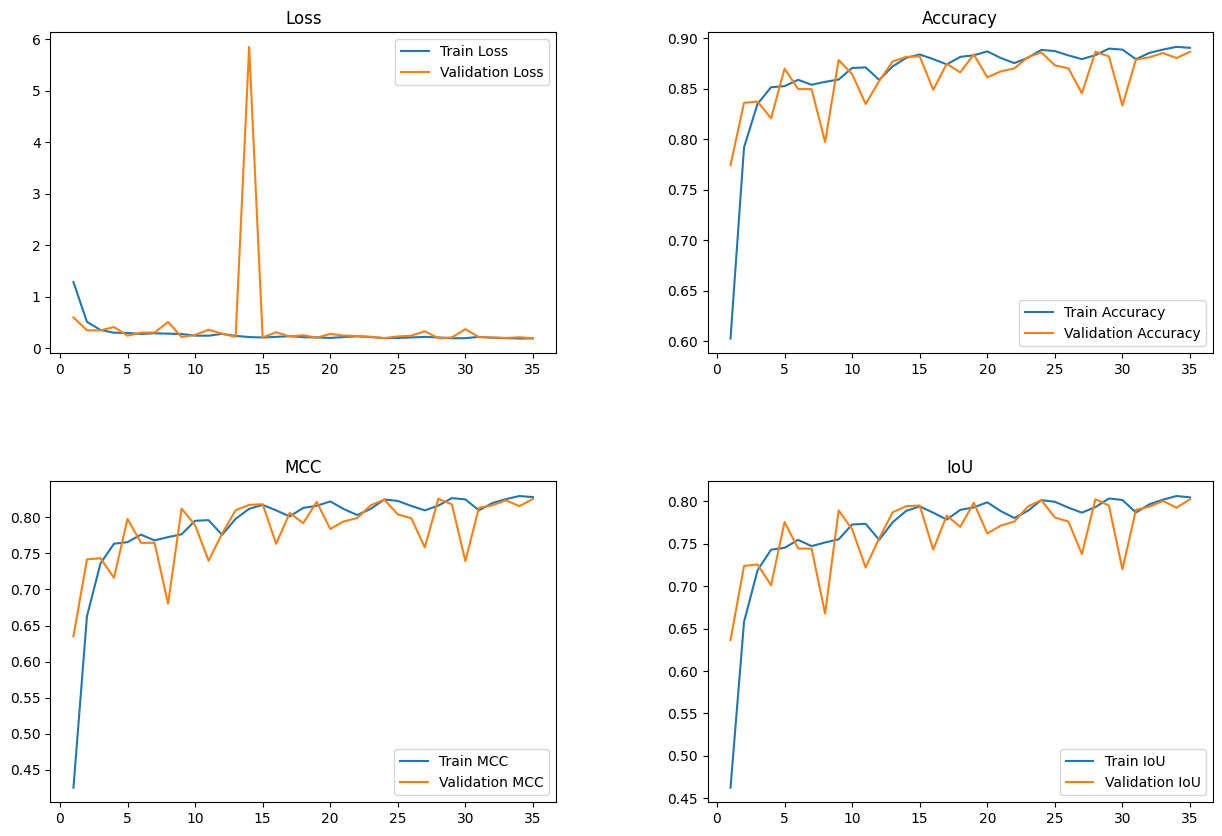

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].plot(np.arange(1, EPOCHS + 1), train_loss, label='Train Loss')
ax[0, 0].plot(np.arange(1, EPOCHS + 1), valid_loss, label='Validation Loss')
ax[0, 0].set_title('Loss')
ax[0, 0].legend()

ax[0, 1].plot(np.arange(1, EPOCHS + 1), train_accuracy, label='Train Accuracy')
ax[0, 1].plot(np.arange(1, EPOCHS + 1), valid_accuracy, label='Validation Accuracy')
ax[0, 1].set_title('Accuracy')
ax[0, 1].legend()

ax[1, 0].plot(np.arange(1, EPOCHS + 1), train_mcc, label='Train MCC')
ax[1, 0].plot(np.arange(1, EPOCHS + 1), valid_mcc, label='Validation MCC')
ax[1, 0].set_title('MCC')
ax[1, 0].legend()

ax[1, 1].plot(np.arange(1, EPOCHS + 1), train_iou, label='Train IoU')
ax[1, 1].plot(np.arange(1, EPOCHS + 1), valid_iou, label='Validation IoU')
ax[1, 1].set_title('IoU')
ax[1, 1].legend()

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

# MODEL TESTING

In [30]:
import gc
import torch

# Clear unnecessary variables
gc.collect()
torch.cuda.empty_cache()

In [31]:
import os
import glob

model_dir = '/kaggle/working/trained_models'
files = glob.glob(os.path.join(model_dir, '*.pth'))

latest_model = files[-1]
latest_model

'/kaggle/working/trained_models/seg_model_3.pth'

In [32]:
MODEL_PATH = latest_model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 4
NUM_TEST_POINTS = 8192

model = PointNetSegHead(num_points=NUM_TEST_POINTS, m=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
print(DEVICE)

cuda


In [33]:
test_dataset = PointCloudDataset(test_df, augmentation=False, num_points=NUM_TEST_POINTS)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [34]:
num_test_batch = int(np.ceil(len(test_dataset)/BATCH_SIZE))

total_test_targets = []
total_test_preds = [] 

with torch.no_grad():

    # place model in evaluation mode
    model = model.eval()

    test_loss = []
    test_accuracy = []
    test_mcc = []
    test_iou = []
    for i, (points, targets) in enumerate(test_loader, 0):

        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)

        preds, _, A = model(points)
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

        loss = criterion(preds, targets, pred_choice)

        # get metrics
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(BATCH_SIZE*NUM_TEST_POINTS)
        mcc = mcc_metric(preds.transpose(2, 1), targets)
        iou = compute_iou(targets, pred_choice)

        # update epoch loss and accuracy
        test_loss.append(loss.item())
        test_accuracy.append(accuracy)
        test_mcc.append(mcc.item())
        test_iou.append(iou.item())

        # add to total targets/preds
        total_test_targets += targets.reshape(-1).cpu().numpy().tolist()
        total_test_preds += pred_choice.reshape(-1).cpu().numpy().tolist()

        if i % 50 == 0:
            print(f'\t [{i}/{num_test_batch}] ' \
                  + f'test loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} ' \
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')

	 [0/502] test loss: 0.3782 accuracy: 6.6378 mcc: 0.7237 iou: 0.7090
	 [50/502] test loss: 0.3606 accuracy: 6.6754 mcc: 0.7329 iou: 0.7159


In [35]:
# display test results
print(f'Test Loss: {np.mean(test_loss):.4f} ' \
        + f'- Test Accuracy: {np.mean(test_accuracy):.4f} ' \
        + f'- Test MCC: {np.mean(test_mcc):.4f} ' \
        + f'- Test IOU: {np.mean(test_iou):.4f}')

Test Loss: 0.3806 - Test Accuracy: 6.5966 - Test MCC: 0.7220 - Test IOU: 0.7068


In [36]:
total_test_targets = np.array(total_test_targets)
total_test_preds = np.array(total_test_preds)

In [ ]:
from sklearn.metrics import confusion_matrix

test_confusion = pd.DataFrame(confusion_matrix(total_test_targets, total_test_preds),
                              columns=list(category_mapping.values()),
                              index=list(category_mapping.values()))

test_confusion

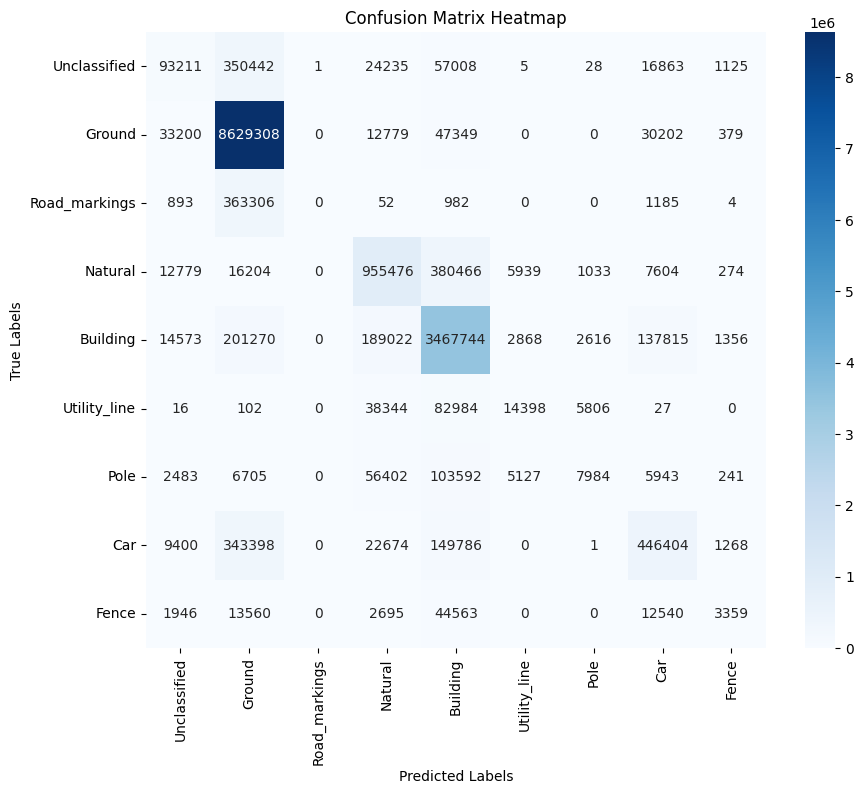

In [38]:
# Plot the heatmap
category_labels = list(category_mapping.values())
plt.figure(figsize=(10, 8))
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues', 
            xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()